# Chapter 5. Fine-tuning Large Language Models

## 5.4 Implementation of natural language inference, semantic similarity calculation, and multiple choice question answering models

### 5.4.2 Semantic Similarity Scoring

#### Preparing the Environment

In [1]:
!pip -q install transformers[ja,torch] datasets matplotlib japanize-matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 68.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 600.9/600.9 kB 32.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 73.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 MB 19.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 41.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.7/71.7 MB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━

In [2]:
from transformers.trainer_utils import set_seed

# Fixed random number seed to 42
set_seed(42)

#### Preparing the Dataset

In [3]:
from pprint import pprint
from datasets import load_dataset

# Load the JSTS data from the llm-book/JGLUE repository on Hugging Face Hub
train_dataset = load_dataset(
    "llm-book/JGLUE", name="JSTS", split="train"
)
valid_dataset = load_dataset(
    "llm-book/JGLUE", name="JSTS", split="validation"
)
# Display in a readable format using pprint
pprint(train_dataset[0])

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

{'label': 0.0,
 'sentence1': '川べりでサーフボードを持った人たちがいます。',
 'sentence2': 'トイレの壁に黒いタオルがかけられています。',
 'sentence_pair_id': '0',
 'yjcaptions_id': '10005_480798-10996-92616'}


In [4]:
pprint(train_dataset.features)

{'label': Value(dtype='float32', id=None),
 'sentence1': Value(dtype='string', id=None),
 'sentence2': Value(dtype='string', id=None),
 'sentence_pair_id': Value(dtype='string', id=None),
 'yjcaptions_id': Value(dtype='string', id=None)}


#### Tokenizer

In [5]:
from transformers import AutoTokenizer

# Specify the model name on Hugging Face Hub
model_name = "cl-tohoku/bert-base-japanese-v3"
# Load the tokenizer from the model name
tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/251 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/231k [00:00<?, ?B/s]

#### Visualizing Dataset Statistics

100%|██████████| 12451/12451 [00:06<00:00, 1870.29it/s]


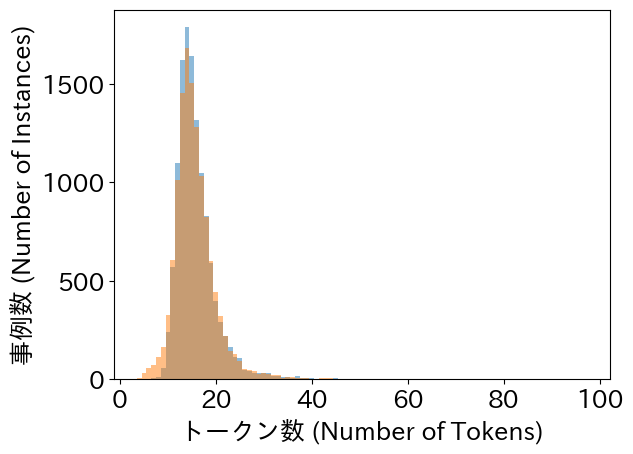

100%|██████████| 1457/1457 [00:01<00:00, 1419.12it/s]


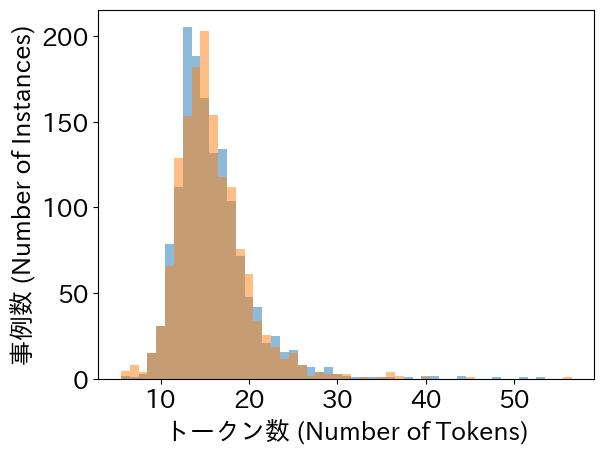

In [6]:
from collections import Counter
import japanize_matplotlib
import matplotlib.pyplot as plt
from datasets import Dataset
from tqdm import tqdm

plt.rcParams["font.size"] = 18  # Increase the font size

def visualize_text_length(dataset: Dataset):
    """Draw a graph of the distribution of token counts in texts within the dataset"""
    # Count the lengths of texts in the dataset
    length_counter1 = Counter()
    length_counter2 = Counter()
    for data in tqdm(dataset):
        length1 = len(tokenizer.tokenize(data["sentence1"]))  # Tokenize and measure the length of sentence1
        length_counter1[length1] += 1
        length2 = len(tokenizer.tokenize(data["sentence2"]))  # Tokenize and measure the length of sentence2
        length_counter2[length2] += 1
    # Draw a bar graph from the values of length_counter
    plt.bar(length_counter1.keys(), length_counter1.values(), width=1.0, alpha=0.5)
    plt.bar(length_counter2.keys(), length_counter2.values(), width=1.0, alpha=0.5)
    plt.xlabel("トークン数 (Number of Tokens)")
    plt.ylabel("事例数 (Number of Instances)")
    plt.show()

visualize_text_length(train_dataset)
visualize_text_length(valid_dataset)

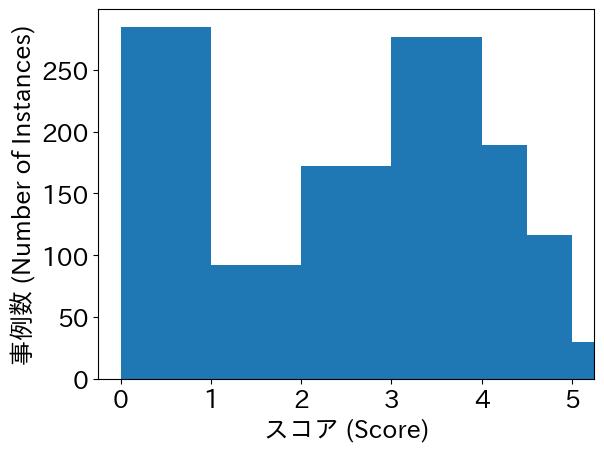

In [7]:
def visualize_scores(dataset: Dataset):
    """Draw a graph of the score distribution in the dataset"""
    # Extract scores from the dataset
    scores = []
    for data in dataset:
        scores.append(data["label"])

    # Draw a histogram of the scores
    plt.hist(scores, width=1.0)
    plt.xlabel("スコア (Score)")
    plt.ylabel("事例数 (Number of Instances)")
    plt.show()

# visualize_scores(train_dataset)
visualize_scores(valid_dataset)

#### Preprocessing Dataset

In [8]:
from transformers import BatchEncoding

def preprocess_text_pair_classification(
    example: dict[str, str | int]
) -> BatchEncoding:
    """Tokenize and convert text pair relationship prediction examples to IDs"""
    # The output is a BatchEncoding object with "input_ids", "token_type_ids", and "attention_mask" as keys,
    # and list[int] as the value
    encoded_example = tokenizer(
        example["sentence1"], example["sentence2"], max_length=128
    )

    # Match the key name "labels" to the argument name expected by the BertForSequenceClassification model's forward method
    # used subsequently
    encoded_example["labels"] = example["label"]
    return encoded_example

In [9]:
encoded_train_dataset = train_dataset.map(
    preprocess_text_pair_classification,
    remove_columns=train_dataset.column_names,
)
encoded_valid_dataset = valid_dataset.map(
    preprocess_text_pair_classification,
    remove_columns=valid_dataset.column_names,
)

Map:   0%|          | 0/12451 [00:00<?, ? examples/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Map:   0%|          | 0/1457 [00:00<?, ? examples/s]

In [10]:
print(encoded_train_dataset[0])

{'input_ids': [2, 1943, 7740, 7234, 457, 12840, 7076, 15950, 500, 13008, 449, 680, 12626, 430, 422, 12995, 385, 3, 17884, 464, 1549, 461, 16568, 32500, 430, 12790, 12504, 456, 422, 12995, 385, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'labels': 0.0}


#### Mini Batch Construction

In [11]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [12]:
batch_inputs = data_collator(encoded_train_dataset[0:4])
pprint({name: tensor.size() for name, tensor in batch_inputs.items()})

{'attention_mask': torch.Size([4, 32]),
 'input_ids': torch.Size([4, 32]),
 'labels': torch.Size([4]),
 'token_type_ids': torch.Size([4, 32])}


#### Preparing the Model

In [13]:
from transformers import AutoModelForSequenceClassification

transformers_model_name = "cl-tohoku/bert-base-japanese-v3"

model = AutoModelForSequenceClassification.from_pretrained(
    transformers_model_name,
    num_labels=1,
    problem_type="regression",
)

config.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/447M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cl-tohoku/bert-base-japanese-v3 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
print(model.forward(**data_collator(encoded_train_dataset[0:4])))

SequenceClassifierOutput(loss=tensor(6.4943, grad_fn=<MseLossBackward0>), logits=tensor([[0.2608],
        [0.3047],
        [0.2998],
        [0.1691]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)


#### Training Execution

In [15]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="output_jsts",  # Folder for saving results
    per_device_train_batch_size=32,  # Batch size during training
    per_device_eval_batch_size=32,  # Batch size during evaluation
    learning_rate=2e-5,  # Learning rate
    lr_scheduler_type="linear",  # Type of learning rate scheduler
    warmup_ratio=0.1,  # Specify the length of learning rate warmup
    num_train_epochs=3,  # Number of training epochs
    save_strategy="epoch",  # Checkpoint save timing
    logging_strategy="epoch",  # Logging timing
    evaluation_strategy="epoch",  # Timing of evaluation with the validation set
    load_best_model_at_end=True,  # Load the best model based on the development set after training
    metric_for_best_model="spearmanr",  # Metric to determine the best model
    fp16=True,  # Enable automatic mixed precision computation
)

In [16]:
import numpy as np
from scipy.stats import pearsonr, spearmanr

def compute_correlation_metrics(
    eval_pred: tuple[np.ndarray, np.ndarray]
) -> dict[str, float]:
    """Calculate various correlation coefficients from predicted scores and correct scores"""
    predictions, labels = eval_pred
    predictions = predictions.squeeze(1)
    return {
        "pearsonr": pearsonr(predictions, labels).statistic,
        "spearmanr": spearmanr(predictions, labels).statistic,
    }

In [17]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    train_dataset=encoded_train_dataset,
    eval_dataset=encoded_valid_dataset,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_correlation_metrics,
)
trainer.train()

Epoch,Training Loss,Validation Loss,Pearsonr,Spearmanr
1,0.978700,0.348528,0.908229,0.866592
2,0.321700,0.349883,0.913619,0.877067


Epoch,Training Loss,Validation Loss,Pearsonr,Spearmanr
1,0.978700,0.348528,0.908229,0.866592
2,0.321700,0.349883,0.913619,0.877067
3,0.232300,0.334654,0.915858,0.878714


TrainOutput(global_step=1170, training_loss=0.5108842442178319, metrics={'train_runtime': 167.4475, 'train_samples_per_second': 223.073, 'train_steps_per_second': 6.987, 'total_flos': 1014585661489602.0, 'train_loss': 0.5108842442178319, 'epoch': 3.0})

#### Evaluating the Model After Training

In [18]:
# Evaluate the model on the validation set
eval_metrics = trainer.evaluate(encoded_valid_dataset)
pprint(eval_metrics)

{'epoch': 3.0,
 'eval_loss': 0.3346541225910187,
 'eval_pearsonr': 0.9158575309020566,
 'eval_runtime': 1.5042,
 'eval_samples_per_second': 968.646,
 'eval_spearmanr': 0.8787139858531036,
 'eval_steps_per_second': 30.582}


#### Save the Model

Save on Google Drive

In [ ]:
# Mount on Google Drive
from google.colab import drive

drive.mount("drive")

In [ ]:
# Copy the saved model to the Google Drive folder
!mkdir -p drive/MyDrive/llm-book
!cp -r output_jsts drive/MyDrive/llm-book

Save on Hugging Face Hub

In [ ]:
from huggingface_hub import login

login()

In [ ]:
# Repository name on Hugging Face Hub
# Replace "YOUR-ACCOUNT" with your own username
repo_name = "YOUR-ACCOUNT/bert-base-japanese-v3-jsts"
# Upload the tokenizer and model
tokenizer.push_to_hub(repo_name)
model.push_to_hub(repo_name)